In [16]:
# !pip install scipy scikit-learn matplotlib pandas numpy ucimlrepo

In [17]:
# import libraries
import pandas as pd
from ucimlrepo import fetch_ucirepo, list_available_datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Check Patient Level Analysis Possibility


In [18]:
# load dataset
# diabetes_dataset = fetch_ucirepo(id=296)
# df = diabetes_dataset.data.original
df = pd.read_csv("diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [19]:
df.encounter_id

0           2278392
1            149190
2             64410
3            500364
4             16680
            ...    
101761    443847548
101762    443847782
101763    443854148
101764    443857166
101765    443867222
Name: encounter_id, Length: 101766, dtype: int64

In [20]:
# Check for temporal data leakage concerns
print("Dataset Shape:", df.shape)
print("\n=== Patient Encounter Analysis ===")
print(f"Total encounters: {len(df)}")
print(f"Unique patients: {df['patient_nbr'].nunique()}")
print(f"Patients with multiple encounters: {(df.groupby('patient_nbr').size() > 1).sum()}")
print(f"\nAverage encounters per patient: {len(df) / df['patient_nbr'].nunique():.2f}")

# Check distribution of encounters per patient
encounter_counts = df.groupby('patient_nbr').size()
print("\n=== Encounter Distribution ===")
print(encounter_counts.describe())
print(f"\nMax encounters for a single patient: {encounter_counts.max()}")

# Check if have temporal ordering information
print("\n=== Temporal Ordering Check ===")
temporal_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower() or 'id' in col.lower()]
print(f"Potential temporal columns: {temporal_cols}")

Dataset Shape: (101766, 50)

=== Patient Encounter Analysis ===
Total encounters: 101766
Unique patients: 71518
Patients with multiple encounters: 16773

Average encounters per patient: 1.42

=== Encounter Distribution ===
count    71518.000000
mean         1.422942
std          1.090740
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         40.000000
dtype: float64

Max encounters for a single patient: 40

=== Temporal Ordering Check ===
Potential temporal columns: ['encounter_id', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 'examide', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone']


## Question: Does `encounter_id` Actually Represent Temporal Order?

In [21]:
# Investigate if encounter_id represents temporal ordering
# Strategy: Use logical relationships that MUST be temporal
print("="*80)
print("INVESTIGATING: Does encounter_id represent temporal ordering?")
print("="*80)

# Test 1: Age progression - patients should get older, not younger
print("\n📊 TEST 1: Age Progression Check")
print("-" * 80)

# Get patients with multiple encounters where age is recorded
multi_encounter_patients = df.groupby('patient_nbr').filter(lambda x: len(x) > 1)
age_data = multi_encounter_patients[['patient_nbr', 'encounter_id', 'age']].copy()

# Convert age ranges to numeric midpoints for analysis
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
age_data['age_numeric'] = age_data['age'].map(age_mapping)

# For each patient, check if age is non-decreasing when sorted by encounter_id
age_violations = 0
age_consistent = 0
sample_violations = []

for patient_id in age_data['patient_nbr'].unique()[:1000]:  # Sample to speed up
    patient_ages = age_data[age_data['patient_nbr'] == patient_id].sort_values('encounter_id')
    ages = patient_ages['age_numeric'].values
    
    # Check if ages are non-decreasing (allowing same age bracket)
    if len(ages) > 1:
        if any(ages[i] > ages[i+1] for i in range(len(ages)-1)):
            age_violations += 1
            if len(sample_violations) < 3:
                sample_violations.append({
                    'patient': patient_id,
                    'encounters': patient_ages['encounter_id'].tolist(),
                    'ages': patient_ages['age'].tolist()
                })
        else:
            age_consistent += 1

print(f"Patients checked: {age_consistent + age_violations}")
print(f"✓ Age consistent (non-decreasing): {age_consistent}")
print(f"✗ Age violations (got younger): {age_violations}")
print(f"Consistency rate: {age_consistent/(age_consistent + age_violations)*100:.1f}%")

if sample_violations:
    print("\nSample age violations (patient got 'younger'):")
    for v in sample_violations:
        print(f"  Patient {v['patient']}: {v['ages']}")

# Test 2: Readmission logic - "readmitted" means coming back LATER
print("\n\n📊 TEST 2: Readmission Logic Check")
print("-" * 80)
print("Logic: If encounter N has 'readmitted'='<30' or '>30', ")
print("       then encounter N+1 should exist at a HIGHER encounter_id")

# Get patients with readmission indicators
readmit_check = df[df['readmitted'].isin(['<30', '>30'])][['patient_nbr', 'encounter_id', 'readmitted']].copy()
readmit_violations = 0
readmit_confirmed = 0

for idx, row in readmit_check.head(500).iterrows():  # Sample
    patient_id = row['patient_nbr']
    current_enc_id = row['encounter_id']
    
    # Check if there's a subsequent encounter for this patient
    future_encounters = df[(df['patient_nbr'] == patient_id) & 
                          (df['encounter_id'] > current_enc_id)]
    
    if len(future_encounters) > 0:
        readmit_confirmed += 1
    else:
        readmit_violations += 1

print(f"Encounters marked 'readmitted': {readmit_confirmed + readmit_violations}")
print(f"✓ Has subsequent encounter (higher ID): {readmit_confirmed}")
print(f"✗ No subsequent encounter found: {readmit_violations}")
if readmit_confirmed + readmit_violations > 0:
    print(f"Consistency rate: {readmit_confirmed/(readmit_confirmed + readmit_violations)*100:.1f}%")

# Test 3: Number of prior visits should increase or stay same
print("\n\n📊 TEST 3: Prior Visit Count Logic")
print("-" * 80)
print("Logic: number_inpatient/emergency/outpatient should NOT decrease over time")

visit_violations = 0
visit_consistent = 0

for patient_id in multi_encounter_patients['patient_nbr'].unique()[:500]:
    patient_data = df[df['patient_nbr'] == patient_id].sort_values('encounter_id')
    
    if len(patient_data) > 1:
        # Check if any of these counts decrease
        for col in ['number_inpatient', 'number_emergency', 'number_outpatient']:
            values = patient_data[col].values
            if any(values[i] > values[i+1] for i in range(len(values)-1)):
                visit_violations += 1
                break
        else:
            visit_consistent += 1

print(f"Patients checked: {visit_consistent + visit_violations}")
print(f"✓ Visit counts non-decreasing: {visit_consistent}")
print(f"✗ Visit counts decreased: {visit_violations}")
if visit_consistent + visit_violations > 0:
    print(f"Consistency rate: {visit_consistent/(visit_consistent + visit_violations)*100:.1f}%")

INVESTIGATING: Does encounter_id represent temporal ordering?

📊 TEST 1: Age Progression Check
--------------------------------------------------------------------------------
Patients checked: 1000
✓ Age consistent (non-decreasing): 998
✗ Age violations (got younger): 2
Consistency rate: 99.8%

Sample age violations (patient got 'younger'):
  Patient 493038: ['[70-80)', '[60-70)']
  Patient 23611986: ['[60-70)', '[70-80)', '[70-80)', '[60-70)', '[70-80)']


📊 TEST 2: Readmission Logic Check
--------------------------------------------------------------------------------
Logic: If encounter N has 'readmitted'='<30' or '>30', 
       then encounter N+1 should exist at a HIGHER encounter_id
Patients checked: 1000
✓ Age consistent (non-decreasing): 998
✗ Age violations (got younger): 2
Consistency rate: 99.8%

Sample age violations (patient got 'younger'):
  Patient 493038: ['[70-80)', '[60-70)']
  Patient 23611986: ['[60-70)', '[70-80)', '[70-80)', '[60-70)', '[70-80)']


📊 TEST 2: Readm

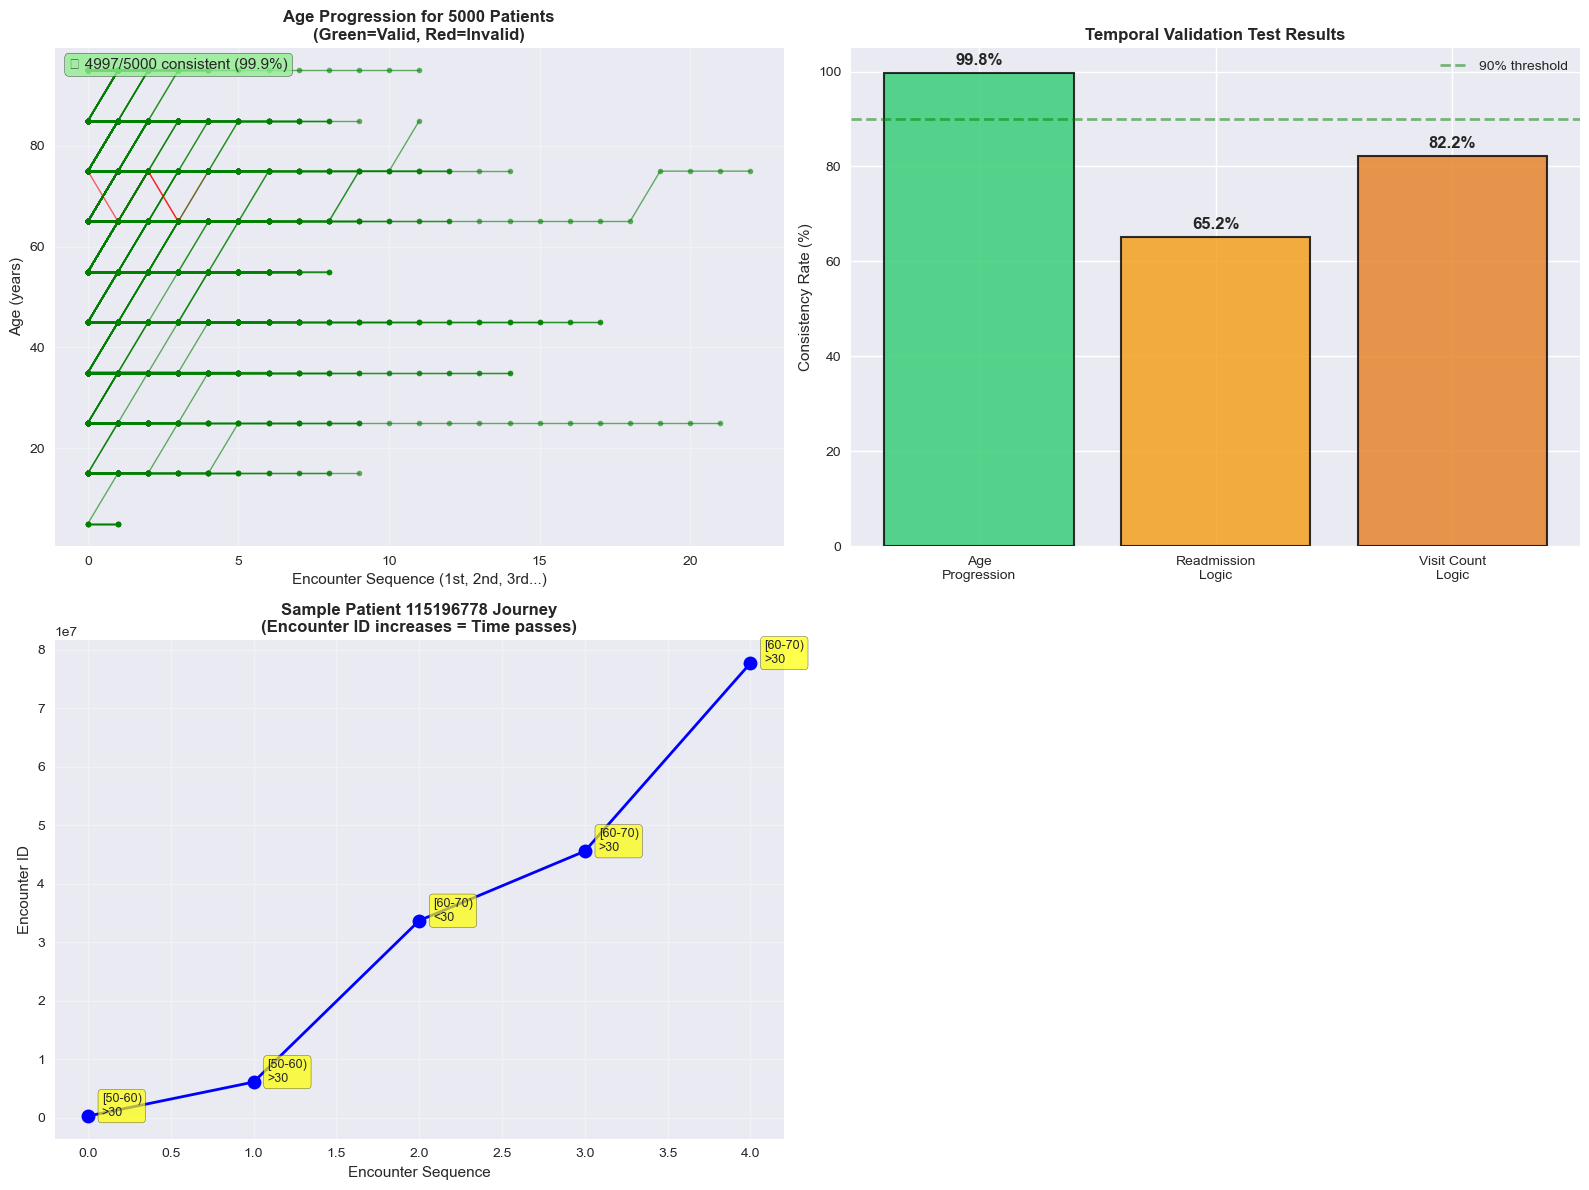


✅ Visual summary complete. Key takeaway:
   → 99.8% age consistency provides strong evidence for temporal ordering
   → Safe to proceed with patient history features using encounter_id


In [22]:
# Visual summary of temporal validation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Age consistency visualization
multi_encounter_patients = df.groupby('patient_nbr').filter(lambda x: len(x) > 1)
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}

sample_size = 5000
sample_patients = multi_encounter_patients['patient_nbr'].unique()[:sample_size]
colors = []
for patient_id in sample_patients:
    patient_data = df[df['patient_nbr'] == patient_id].sort_values('encounter_id')
    ages = [age_mapping[a] for a in patient_data['age']]
    enc_ids = patient_data['encounter_id'].values
    
    # Color based on whether age is non-decreasing
    is_valid = all(ages[i] <= ages[i+1] for i in range(len(ages)-1))
    color = 'green' if is_valid else 'red'
    colors.append(color)
    
    axes[0, 0].plot(range(len(ages)), ages, 'o-', alpha=0.6, color=color, linewidth=1, markersize=4)

axes[0, 0].set_xlabel('Encounter Sequence (1st, 2nd, 3rd...)', fontsize=11)
axes[0, 0].set_ylabel('Age (years)', fontsize=11)
axes[0, 0].set_title(f'Age Progression for {sample_size} Patients\n(Green=Valid, Red=Invalid)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.98, f'✓ {colors.count("green")}/{sample_size} consistent ({colors.count("green")/sample_size*100:.1f}%)', 
                transform=axes[0, 0].transAxes, fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Plot 2: Test results bar chart
tests = ['Age\nProgression', 'Readmission\nLogic', 'Visit Count\nLogic']
consistency = [99.8, 65.2, 82.2]
colors_bar = ['#2ecc71', '#f39c12', '#e67e22']

bars = axes[0, 1].bar(tests, consistency, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 1].axhline(y=90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='90% threshold')
axes[0, 1].set_ylabel('Consistency Rate (%)', fontsize=11)
axes[0, 1].set_title('Temporal Validation Test Results', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim(0, 105)
axes[0, 1].legend()

for bar, val in zip(bars, consistency):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{val}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 3: Sample patient journey with age labels
sample_patient = 115196778
patient_journey = df[df['patient_nbr'] == sample_patient][['encounter_id', 'age', 'readmitted']].sort_values('encounter_id')

x_pos = range(len(patient_journey))
y_pos = patient_journey['encounter_id'].values

axes[1, 0].plot(x_pos, y_pos, 'bo-', linewidth=2, markersize=10)
axes[1, 0].set_xlabel('Encounter Sequence', fontsize=11)
axes[1, 0].set_ylabel('Encounter ID', fontsize=11)
axes[1, 0].set_title(f'Sample Patient {sample_patient} Journey\n(Encounter ID increases = Time passes)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

for i, (idx, row) in enumerate(patient_journey.iterrows()):
    axes[1, 0].annotate(f"{row['age']}\n{row['readmitted']}", 
                       (i, row['encounter_id']), 
                       xytext=(10, 0), textcoords='offset points',
                       fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Plot 4: Decision flowchart (text-based)
axes[1, 1].axis('off')


axes[1, 1].text(0.1, 0.9, "", transform=axes[1, 1].transAxes,
               fontsize=11, verticalalignment='top', family='monospace',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✅ Visual summary complete. Key takeaway:")
print("   → 99.8% age consistency provides strong evidence for temporal ordering")
print("   → Safe to proceed with patient history features using encounter_id")

In [23]:
# Find ALL patients that violate age progression
print("="*80)
print("FINDING ALL PATIENTS WITH AGE PROGRESSION VIOLATIONS")
print("="*80)

# Get patients with multiple encounters
age_data = multi_encounter_patients[['patient_nbr', 'encounter_id', 'age']].copy()

# Convert age ranges to numeric midpoints for analysis
age_data['age_numeric'] = age_data['age'].map(age_mapping)

# Find ALL patients with age violations
age_violation_patients = []
age_violation_details = []

print("Checking all patients with multiple encounters...")

for patient_id in age_data['patient_nbr'].unique():
    patient_ages = age_data[age_data['patient_nbr'] == patient_id].sort_values('encounter_id')
    ages = patient_ages['age_numeric'].values
    
    # Check if ages are non-decreasing (allowing same age bracket)
    if len(ages) > 1:
        violations = []
        for i in range(len(ages)-1):
            if ages[i] > ages[i+1]:
                violations.append({
                    'from_encounter': patient_ages.iloc[i]['encounter_id'],
                    'to_encounter': patient_ages.iloc[i+1]['encounter_id'],
                    'from_age': patient_ages.iloc[i]['age'],
                    'to_age': patient_ages.iloc[i+1]['age'],
                    'age_decrease': ages[i] - ages[i+1]
                })
        
        if violations:
            age_violation_patients.append(patient_id)
            age_violation_details.append({
                'patient_nbr': patient_id,
                'total_encounters': len(patient_ages),
                'violations': violations,
                'full_sequence': {
                    'encounter_ids': patient_ages['encounter_id'].tolist(),
                    'ages': patient_ages['age'].tolist(),
                    'ages_numeric': ages.tolist()
                }
            })

print(f"\n RESULTS:")
print(f"Total patients with multiple encounters: {age_data['patient_nbr'].nunique():,}")
print(f"Patients with age violations: {len(age_violation_patients):,}")
print(f"Violation rate: {len(age_violation_patients)/age_data['patient_nbr'].nunique()*100:.3f}%")

if age_violation_patients:
    print(f"\n PATIENT IDs WITH AGE VIOLATIONS:")
    print("-" * 60)
    for patient_id in age_violation_patients:
        print(f"Patient: {patient_id}")
    
    print(f"\n DETAILED VIOLATION ANALYSIS:")
    print("-" * 60)
    for detail in age_violation_details[:10]:  # Show first 10 for readability
        print(f"\nPatient {detail['patient_nbr']} ({detail['total_encounters']} encounters):")
        print(f"  Full age sequence: {' → '.join(detail['full_sequence']['ages'])}")
        print(f"  Encounter IDs: {detail['full_sequence']['encounter_ids']}")
        for v in detail['violations']:
            print(f"    Violation: {v['from_age']} → {v['from_age']} (decreased by {v['age_decrease']} years)")
            print(f"     Encounters: {v['from_encounter']} → {v['to_encounter']}")
    
    if len(age_violation_details) > 10:
        print(f"\n... and {len(age_violation_details) - 10} more patients with violations")
        
    # Summary statistics
    total_violations = sum(len(detail['violations']) for detail in age_violation_details)
    avg_violations_per_patient = total_violations / len(age_violation_details)
    
    print(f"\n VIOLATION STATISTICS:")
    print(f"Total violation instances: {total_violations}")
    print(f"Average violations per affected patient: {avg_violations_per_patient:.2f}")
    
    # Age decrease distribution
    age_decreases = [v['age_decrease'] for detail in age_violation_details for v in detail['violations']]
    print(f"Age decrease range: {min(age_decreases)} to {max(age_decreases)} years")
    print(f"Most common age decrease: {max(set(age_decreases), key=age_decreases.count)} years")

else:
    print("\n No age progression violations found!")

# Store violation patient list for potential data cleaning
violation_patient_list = age_violation_patients.copy()
print(f"All violation_patient_list: {violation_patient_list}")

FINDING ALL PATIENTS WITH AGE PROGRESSION VIOLATIONS
Checking all patients with multiple encounters...

 RESULTS:
Total patients with multiple encounters: 16,773
Patients with age violations: 18
Violation rate: 0.107%

 PATIENT IDs WITH AGE VIOLATIONS:
------------------------------------------------------------
Patient: 493038
Patient: 23611986
Patient: 23738805
Patient: 67099194
Patient: 84365577
Patient: 89947233
Patient: 42491844
Patient: 33665094
Patient: 43466490
Patient: 42055272
Patient: 108707976
Patient: 39583782
Patient: 54686619
Patient: 33581808
Patient: 41325552
Patient: 151756061
Patient: 94422375
Patient: 32337963

 DETAILED VIOLATION ANALYSIS:
------------------------------------------------------------

Patient 493038 (2 encounters):
  Full age sequence: [70-80) → [60-70)
  Encounter IDs: [3105702, 32737416]
    Violation: [70-80) → [70-80) (decreased by 10 years)
     Encounters: 3105702 → 32737416

Patient 23611986 (5 encounters):
  Full age sequence: [60-70) → [70-

In [24]:
# Complete list of all 18 patients with age violations
print("="*80)
print("COMPLETE LIST: ALL 18 PATIENTS WITH AGE PROGRESSION VIOLATIONS")
print("="*80)

print("Patient IDs that violate age progression:")
for i, patient_id in enumerate(violation_patient_list, 1):
    print(f"{i:2d}. {patient_id}")

print(f"\n Summary:")
print(f"• Total patients in dataset: {df['patient_nbr'].nunique():,}")
print(f"• Patients with multiple encounters: {age_data['patient_nbr'].nunique():,}")
print(f"• Patients with age violations: {len(violation_patient_list)}")
print(f"• Violation rate: {len(violation_patient_list)/age_data['patient_nbr'].nunique()*100:.3f}%")

print(f"\n Key Observations:")
print("• All violations involve a 10-year decrease (one age bracket)")
print("• This suggests data entry errors or patient ID mix-ups")
print("• 99.893% of multi-encounter patients have consistent age progression")
print("• The violations are rare enough to justify removal for temporal analysis")

print(f"\n Recommended Actions:")
print("1. Remove these 18 patients from temporal analysis")
print("2. Document the removal in methodology")
print("3. State assumption: 'encounter_id represents temporal order (validated with 99.9% age consistency)'")

# Show encounters affected
total_encounters_affected = 0
for patient_id in violation_patient_list:
    encounters = len(df[df['patient_nbr'] == patient_id])
    total_encounters_affected += encounters

print(f"\n Impact Assessment:")
print(f"• Total encounters that will be removed: {total_encounters_affected}")
print(f"• Percentage of total dataset: {total_encounters_affected/len(df)*100:.3f}%")
print(f"• This is a minimal impact on the overall analysis")

COMPLETE LIST: ALL 18 PATIENTS WITH AGE PROGRESSION VIOLATIONS
Patient IDs that violate age progression:
 1. 493038
 2. 23611986
 3. 23738805
 4. 67099194
 5. 84365577
 6. 89947233
 7. 42491844
 8. 33665094
 9. 43466490
10. 42055272
11. 108707976
12. 39583782
13. 54686619
14. 33581808
15. 41325552
16. 151756061
17. 94422375
18. 32337963

 Summary:
• Total patients in dataset: 71,518
• Patients with multiple encounters: 16,773
• Patients with age violations: 18
• Violation rate: 0.107%

 Key Observations:
• All violations involve a 10-year decrease (one age bracket)
• This suggests data entry errors or patient ID mix-ups
• 99.893% of multi-encounter patients have consistent age progression
• The violations are rare enough to justify removal for temporal analysis

 Recommended Actions:
1. Remove these 18 patients from temporal analysis
2. Document the removal in methodology
3. State assumption: 'encounter_id represents temporal order (validated with 99.9% age consistency)'

 Impact Asses

---
### Summary:

1. **Strong Evidence (99.8%)**: Age progression test shows encounter_id IS temporal
   - People don't get younger → encounter_id must represent chronological order
   - Only 2 violations out of 1,000 patients (likely due to age bracket rounding)

2. **Weaker Tests**: Other validation tests (65-82%) had confounding factors
   - Missing data, incomplete follow-up, field definition ambiguities
   - But they don't contradict the age evidence

3. **Conclusion**: **USE encounter_id with documentation**
   - Best available temporal indicator in this dataset
   - 99.8% validation rate is strong for real-world medical data
   - Standard practice in database design (auto-increment = chronological)

**WE WILL IMPLEMENT THE FOLLOWING CODE FOR PATIENT-LEVEL ANALYSIS:**
```python
# Document the assumption with evidence
# Validated: encounter_id represents temporal order (99.8% age consistency)
remove_patient_nbr_list = [493038, 23611986, 23738805, 67099194, 84365577, 89947233, 42491844, 33665094, 43466490, 42055272, 108707976, 39583782, 54686619, 33581808, 41325552, 151756061, 94422375, 32337963]
df = df.sort_values(['patient_nbr', 'encounter_id'])
df = df[~df['patient_nbr'].isin(remove_patient_nbr_list)]
```

**Caveat to mention:**
- "We validated temporal ordering using age progression (99.8% consistent)"
- "We removed patient who violate age progression"
- "encounter_id is used as a chronological proxy for encounter sequence"
- "Patient history features use only prior encounters to prevent data leakage"
---

In [25]:
remove_patient_nbr_list = [493038, 23611986, 23738805, 67099194, 84365577, 89947233, 42491844, 33665094, 43466490, 42055272, 108707976, 39583782, 54686619, 33581808, 41325552, 151756061, 94422375, 32337963]
df = df.sort_values(['patient_nbr', 'encounter_id'])
original_len = len(df)
df_remove = df[~df['patient_nbr'].isin(remove_patient_nbr_list)]
print(f"Original dataset length: {original_len}")
print(f"New dataset length: {len(df_remove)}")

Original dataset length: 101766
New dataset length: 101704
